Pandas Version:  2.2.0
Numpy Version:  1.26.0
PyTorch Version:  2.5.0
Seed: 1968
Epoch 0
-------------------------------
Train Metrics are inaccurate due to dropout, noise, and load balancing.


Loss            Accuracy            Epoch
                                Train Validation    Train Validation      
@ Lowest Validation Loss       1.1298     0.1115   0.5588     0.9429    11
@ Highest Validation Accuracy  1.1298     0.1115   0.5588     0.9429    11

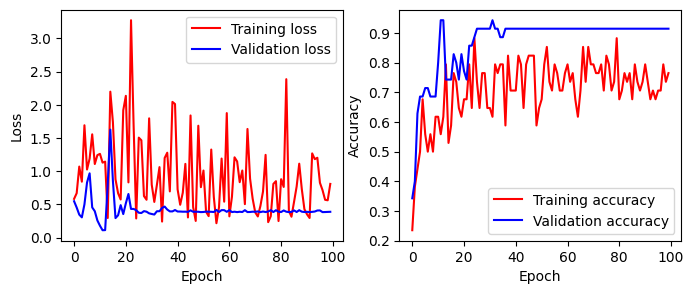

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

print("Pandas Version: ", pd.__version__)
print("Numpy Version: ", np.__version__)
print("PyTorch Version: ", torch.__version__)

seed = np.random.randint(10000)
seed = 1968
print("Seed: %d" % seed)
torch.manual_seed(seed)

import matplotlib.pyplot as plt

# Step 1: Load the microarray data
X = pd.read_csv("./datasets/pp5i_train.gr.csv").set_index("SNO").rename_axis(None, axis=0)
mapping = {'MED': 0, 'RHB': 1, 'EPD': 2, 'MGL': 3, 'JPA': 4}
y = pd.read_csv("./datasets/pp5i_train_class.txt").set_index(X.T.index).apply(lambda x: mapping[x['Class']], axis=1)

# Step 2: Split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.5,
                                                    stratify=y, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Step 3: Clipping the data 
# because the datasets was processed with MAS-4 software which generate negative values,
# and values below 100 are less reproducible and above 16,000 tend to have non-linear correlation with the actual gene expression.
# For dataset with more noise, lower bound of 100 is used.
X_train_clipped = X_train_tensor.detach().clone().clamp(20, 16000)

# Step 4: Filter genes based on maximum-to-minimum ratio
# because many genes are not vary enough to be informative.
mask = X_train_tensor.max(dim=0).values.div(X_train_tensor.min(dim=0).values) > 2
X_train_filtered = X_train_clipped.detach().clone()[:, mask]

# Step 5: Transforming the data with log2 
# because genes with high values tend to have higher variance,
# and log2 transformation is used to reduce the variance of each gene.
X_train_log2 = X_train_filtered.detach().clone().log2()

# Step 6: Standardize the data
# to remove the differences in scale between genes, 
# ensuring that genes with high values do not disproportionately influence the model.
mu = X_train_log2.mean(dim=0)
sigma = X_train_log2.std(dim=0)
sigma[sigma == 0] = 1 # prevent division by zero
X_train_scaled = X_train_log2.detach().clone().sub(mu).div(sigma)

# Step 7: Save the mask, mu, and sigma
torch.save({'mask': mask, 'mu': mu, 'sigma': sigma}, "weights/preprocess_params.pt")

class PreprocessTransforms:
  def __init__(self, mask: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor):
    self.mask = mask
    self.mu = mu
    self.sigma = sigma
  
  def __call__(self, X: torch.Tensor) -> torch.Tensor:
    X_clamped = X.clamp(20, 16000)
    X_filtered = X_clamped[:, self.mask]
    X_log2 = X_filtered.log2()
    X_scaled = X_log2.sub(self.mu).div(self.sigma)
    return X_scaled

class GeneExpressionDataset(Dataset):
  def __init__(self, X: torch.Tensor, y: torch.Tensor, transform: PreprocessTransforms):
    self.X = transform(X)
    self.y = y
  
  def __len__(self):
    return self.X.size(0)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# Step 8: Create DataLoader
train_dataset = TensorDataset(X_train_scaled, y_train_tensor)

preprocess_params = torch.load("weights/preprocess_params.pt", weights_only=True)
preprocess_transforms = PreprocessTransforms(mask=preprocess_params['mask'],
                                             mu=preprocess_params['mu'],
                                             sigma=preprocess_params['sigma'])
val_dataset = GeneExpressionDataset(X_val_tensor, y_val_tensor, 
                                    transform=preprocess_transforms)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=True)

# Define the Expert Network
class Expert(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc = nn.Linear(input_dim, output_dim)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = torch.relu(self.fc(x))
    # Apply dropout
    # to prevent the model from overfitting
    x = self.dropout(x)
    return x

# Define the Gating Network
class Router(nn.Module):
  def __init__(self, input_dim, num_experts):
    super().__init__()
    self.fc = nn.Linear(input_dim, num_experts)
  
  # [batch_size, input_dim] -> [batch_size, num_experts]
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.fc(x)
    if self.training:
      # Add noise to the logits drawn from a normal distribution with mean 0 and variance 0.1
      # to encourage the model to use all the experts.
      x += torch.randn_like(x) * (0.1**0.5) 
    return x

def topk(router_logits: torch.Tensor, top_k: int, dim: int, expert_capacity: int) -> tuple[torch.Tensor, torch.Tensor]:
  """
  router_logits: [batch_size, num_experts]

  torch.topk with `expert_capacity` constraint.
  Suppose each expert can be used at most 2 times in a batch and 
  torch.topk use an `Expert` 3 times in a batch.
  We will replace the 3rd usage of the expert with the next best expert for the sample.
  """
  batch_size = router_logits.size(0)
  num_experts = router_logits.size(1)
  
  sorted_indices = torch.argsort(router_logits, dim=dim, descending=True)
  topk_logits, topk_indices = torch.topk(router_logits, top_k, dim=dim) # [batch_size, top_k]
  new_logits, new_indices = topk_logits.clone(), topk_indices.clone()

  expert_assigned = torch.zeros(num_experts)
  for i in range(batch_size):
    if (expert_assigned == expert_capacity).sum() == num_experts: # expert_capacity is full
      new_logits[i] = 0
      new_indices[i] = -1
      continue

    for j in range(top_k):
      expert_index = sorted_indices[i, j]
      if expert_assigned[expert_index] < expert_capacity:
        expert_assigned[expert_index] += 1
        continue

      for next_expert_index in sorted_indices[i, j:]:
        if expert_assigned[next_expert_index] == expert_capacity: # expert_capacity is full
          continue

        if next_expert_index in new_indices[i]: # prevent duplicate
          continue

        new_logits[i, j] = router_logits[i, next_expert_index]
        new_indices[i, j] = next_expert_index
        expert_assigned[next_expert_index] += 1
        break
  
  return new_logits, new_indices

# Define the MoE Model
class MoE(nn.Module):
  def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.num_experts = num_experts
    self.top_k = top_k
    
    # Create the experts
    self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])

    # Create the router
    self.router = Router(input_dim, num_experts)
  
  # Note: The gradients are computed 
  # based on how much each expert's output contribution to the loss.
  # If the an expert is used only once for a specific sample,
  # it will receive a gradient based only on that single sample's contribution
  # to the overall loss.
  def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Args:
    - x: [batch_size, input_dim]
    
    Returns:
    - weighted_outputs: [num_experts, batch_size, output_dim]
    - router_logits: [batch_size, num_experts]
    - topk_indices: [batch_size, top_k]
    """
    batch_size = x.size(0)

    # Get router logts
    router_logits: torch.Tensor = self.router(x) # [batch_size, num_experts]

    # Get the top-k expert indices for each sample in the batch
    expert_capacity = int(batch_size * self.top_k / self.num_experts)
    if self.training:
      topk_logits, topk_indices = topk(router_logits, self.top_k, dim=-1, expert_capacity=expert_capacity)
    else:
      topk_logits, topk_indices = torch.topk(router_logits, self.top_k, dim=-1)

    weighted_outputs = torch.zeros(self.num_experts, batch_size, self.output_dim)
    for i, expert in enumerate(self.experts):
      expert_mask = (topk_indices == i).any(dim=-1) # [top_k]
      expert_logits = topk_logits[topk_indices == i]

      if expert_mask.any():
        expert_input = x[expert_mask]
        expert_output = expert(expert_input)

        weighted_output = expert_output * expert_logits.unsqueeze(-1)

        weighted_outputs[i][expert_mask] += weighted_output

    return weighted_outputs, router_logits, topk_indices
  
class Network(nn.Module):
  def __init__(self, input_dim: int, output_dim: int, num_experts: int, top_k: int):
    super().__init__()
    self.moe = MoE(input_dim, output_dim, num_experts, top_k)
  
  def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    return self.moe(x)

# [batch_size, num_experts] -> [1]
def load_balancing_loss_fn(router_logits: torch.Tensor) -> torch.Tensor:
  """
  If the sum of the router logits is not balanced across the experts,
  the standard deviation of the sum will be high.
  If the sum of the router logits is balanced across the experts,
  the standard deviation of the sum will be low.
  """
  return router_logits.sum(0).std(0)

# [num_experts, batch_size, output_dim], [batch_size, output_dim] -> [1]
def contrastive_loss(weighted_outputs: torch.Tensor, topk_indices: torch.Tensor) -> torch.Tensor:
  """
  If the output of the experts is similar, the contrastive loss will be low.

  Expected cases:
  1. Within a batch, a sample may be processed by n experts,
  the other samples may be processed by m experts.

  3 experts:
  1. $D_{KL}(p_0||p_1)$, $D_{KL}(p_1||p_0)$
  2. $D_{KL}(p_0||p_2)$, $D_{KL}(p_2||p_0)$
  3. $D_{KL}(p_1||p_2)$, $D_{KL}(p_2||p_1)$

  """
  num_experts = weighted_outputs.size(0)
  kl_div_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
  
  loss = 0
  for i in range(num_experts):
    for j in range(i+1, num_experts):
      # Version A: Assumption that each expert is guaranteed to process each sample
      # p = torch.log_softmax(weighted_outputs[i], dim=-1)
      # q = torch.log_softmax(weighted_outputs[j], dim=-1)
      # d_kl_pq = kl_div_loss(p, q)
      # d_kl_qp = kl_div_loss(q, p)
      # loss += d_kl_pq + d_kl_qp

      # Version B: Assumption that each expert is not guaranteed to process each sample
      # Initialize a mask to ignore samples that are not processed by both experts
      mask = (topk_indices == i).any(dim=-1) & (topk_indices == j).any(dim=-1)
      if mask.any():
        p = torch.log_softmax(weighted_outputs[i][mask], dim=-1)
        q = torch.log_softmax(weighted_outputs[j][mask], dim=-1)
        d_kl_pq = kl_div_loss(p, q)
        d_kl_qp = kl_div_loss(q, p)
        loss += d_kl_pq + d_kl_qp

  return loss

class EarlyStopper:
  """
  Reference:
  https://stackoverflow.com/a/73704579/13285583
  """
  def __init__(self, count_threshold: int, value_delta_threshold: int, goal: str):
    self.count_threshold = count_threshold
    self.value_delta_threshold = value_delta_threshold
    self.counter = 0
    self.goal = goal
    if self.goal == "minimize":
      self.best_score = float('inf')
    elif self.goal == "maximize":
      self.best_score = float('-inf')
    else:
      raise ValueError("mode should be 'minimize' or 'maximize'")

  def __call__(self, score: float):
    if self.goal == "minimize":
      if score < self.best_score:
        self.best_score = score
        self.counter = 0
      elif score - self.best_score > self.value_delta_threshold:
        self.counter += 1
        if self.counter >= self.count_threshold:
          return True
    elif self.goal == "maximize":
      if score > self.best_score:
        self.best_score = score
        self.counter = 0
      elif self.best_score - score > self.value_delta_threshold:
        self.counter += 1
        if self.counter >= self.count_threshold:
          return True
    return False

# Training the MoE model
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, 
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  model.train()
  for _, (X, y) in enumerate(dataloader):
    weighted_outputs, router_logits, topk_indices = model(X)
    pred = weighted_outputs.sum(0)
    loss: torch.Tensor = loss_fn(pred, y)
    loss += load_balancing_loss_fn(router_logits) * 1e-2
    loss += contrastive_loss(weighted_outputs, topk_indices) * 1e-4
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    avg_loss += loss.item()
    avg_accuracy += (pred.argmax(-1) == y).sum().item()

  # loss, current = loss.item(), batch_index * batch_size + len(X)
  # print(f"loss: {loss:>7f} [{current:>2d}/{size:>2d}]")

  avg_loss /= batch_size
  avg_accuracy /= size

  return avg_loss, avg_accuracy

# Evaluate the MoE model
def val_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> torch.Tensor:
  model.eval()
  size = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  avg_loss, avg_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      weighted_outputs, _, topk_indices = model(X)
      pred = weighted_outputs.sum(0)
      loss = loss_fn(pred, y)
      loss += contrastive_loss(weighted_outputs, topk_indices) * 1e-4
      avg_loss += loss.item()
      avg_accuracy += (pred.argmax(-1) == y).sum().item()
  
  avg_accuracy /= size
  avg_loss /= batch_size
  # print(f'Val Error: \n Accuracy: {100 * correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

  return avg_loss, avg_accuracy

# Instantiate the MoE model
_, n_features = X_train_scaled.shape
n_classes = 5
num_experts = 4
top_k = 2
model = Network(input_dim=n_features, output_dim=n_classes, num_experts=num_experts, top_k=top_k)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max')
early_stopping = EarlyStopper(count_threshold=5, value_delta_threshold=5e-1, goal="maximize")
epochs = 100

train_losses, train_accuracies = np.zeros(epochs), np.zeros(epochs)
val_losses, val_accuracies = np.zeros(epochs), np.zeros(epochs)
best_val_accuracy = 0
for t in range(epochs):
  if t % 1000 == 0:
    print(f"Epoch {t}\n-------------------------------")
  train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer) # Train the model
  train_losses[t] = train_loss
  train_accuracies[t] = train_accuracy
  val_loss, val_accuracy = val_loop(val_loader, model, loss_fn) # Evaluate the model on the validation set
  val_losses[t] = val_loss
  val_accuracies[t] = val_accuracy
  scheduler.step(val_accuracy)

  # Save the best model
  if best_val_accuracy < val_accuracy:
    torch.save({'input_dim': n_features,
                'output_dim': n_classes,
                'num_experts': num_experts, 
                'top_k': top_k, 
                'state_dict': model.state_dict()}, 
               f"weights/model_weights_0_{n_features}_{n_classes}_{num_experts}_{top_k}.pth")
    best_val_accuracy = val_accuracy
  
  # Early stopping
  if early_stopping(val_accuracy):
    train_losses, train_accuracies = train_losses[:t+1], train_accuracies[:t+1]
    val_losses, val_accuracies = val_losses[:t+1], val_accuracies[:t+1]
    break

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(range(t+1), train_losses, 'r', label='Training loss')
plt.plot(range(t+1), val_losses, 'b', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(t+1), train_accuracies, 'r', label='Training accuracy')
plt.plot(range(t+1), val_accuracies, 'b', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print("Train Metrics are inaccurate due to dropout, noise, and load balancing.")

display(pd.DataFrame({("Loss", "Train"):            [train_losses[val_losses.argmin()].round(4), train_losses[val_accuracies.argmax()].round(4)],
                      ("Loss", "Validation"):       [val_losses.min().round(4), val_losses[val_accuracies.argmax()].round(4)],
                      ("Accuracy", "Train"):        [train_accuracies[val_losses.argmin()].round(4), train_accuracies[val_accuracies.argmax()].round(4)],
                      ("Accuracy", "Validation"):   [val_accuracies[val_losses.argmin()].round(4), val_accuracies.max().round(4)],
                      ("Epoch", ""):                [val_losses.argmin(), val_accuracies.argmax()]},
                     index=["@ Lowest Validation Loss", "@ Highest Validation Accuracy"]))

In [2]:
# Evaluation Results
model_weights = torch.load(f'weights/model_weights_0_{n_features}_{n_classes}_{num_experts}_{top_k}.pth', weights_only=True)
model = Network(input_dim=model_weights['input_dim'],
                output_dim=model_weights['output_dim'],
                num_experts=model_weights['num_experts'],
                top_k=model_weights['top_k'])
model.load_state_dict(model_weights['state_dict'])

X_tensor = torch.tensor(X.T.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
Xy_dataset = GeneExpressionDataset(X_tensor, y_tensor, transform=preprocess_transforms)
Xy_dataloader = DataLoader(Xy_dataset, batch_size=69, shuffle=True)

avg_train_loss, avg_train_accuracy = val_loop(train_loader, model, loss_fn)
avg_val_loss, avg_val_accuracy = val_loop(val_loader, model, loss_fn)
avg_all_loss, avg_all_accuracy = val_loop(Xy_dataloader, model, loss_fn)

pd.DataFrame({("Loss", "Train"):            [avg_train_loss],
              ("Loss", "Validation"):       [avg_val_loss],
              ("Loss", "All"):              [avg_all_loss],
              ("Accuracy", "Train"):        [avg_train_accuracy],
              ("Accuracy", "Validation"):   [avg_val_accuracy],
              ("Accuracy", "All"):          [avg_all_accuracy]
             },
             index=["Average"]).round(4)

Loss                    Accuracy                  
          Train Validation     All    Train Validation    All
Average  0.0082     0.1098  0.0036      1.0     0.9429  0.971

In [3]:
reverse_mapping = {v: k for k,v in mapping.items()}
y_true = [reverse_mapping[i.item()] for i in val_dataset.y]
X_val_preprocessed = preprocess_transforms(X_val_tensor)
weighted_outputs, _, _ = model(X_val_preprocessed)
y_pred = [reverse_mapping[i.item()] for i in torch.softmax(weighted_outputs, dim=-1).sum(dim=0).softmax(dim=-1).argmax(dim=-1)]

df = pd.DataFrame({"True": y_true, "Predicted": y_pred}, index=X_val.index)
print("Validation set size: %d" % df.shape[0])
df[df["True"] != df["Predicted"]]

Validation set size: 35


,True,Predicted
53,RHB,MED
21,MED,MGL


In [4]:
# Calculate active parameters during inference
router_parameters = sum(p.numel() for p in model.moe.router.parameters())
experts_parameters = sum(p.numel() for p in model.moe.experts.parameters())
experts_active_parameters = int(experts_parameters * top_k / num_experts)
model_parameters = sum(p.numel() for p in model.parameters())
model_active_parameters = router_parameters + experts_active_parameters
pd.DataFrame({"Parameters": [router_parameters, 
                             experts_parameters,
                             model_parameters],
              "Active Parameters": [router_parameters,
                                    experts_active_parameters,
                                    model_active_parameters],
              "Ratio": [1, experts_active_parameters / experts_parameters, model_active_parameters / model_parameters],},
              index=["Router", "Experts", "Total Parameters"]).round(3)

,Parameters,Active Parameters,Ratio
Router,16816,16816,1.000
Experts,84080,42040,0.500
Total Parameters,100896,58856,0.583


In [5]:
# Inference
import pandas as pd
import torch

X_test = pd.read_csv("./datasets/pp5i_test.gr.csv").set_index("SNO").rename_axis(None, axis=0).T
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
preprocess_params = torch.load("weights/preprocess_params.pt", weights_only=True)
preprocess_transforms = PreprocessTransforms(mask=preprocess_params['mask'],
                                             mu=preprocess_params['mu'],
                                             sigma=preprocess_params['sigma'])
X_preprocessed = preprocess_transforms(X_test_tensor)

model_weights = torch.load(f'weights/model_weights_0_{n_features}_{n_classes}_{num_experts}_{top_k}.pth', weights_only=True)
model = Network(input_dim=model_weights['input_dim'],
                output_dim=model_weights['output_dim'],
                num_experts=model_weights['num_experts'],
                top_k=model_weights['top_k'])
model.load_state_dict(model_weights['state_dict'])

model.eval()
weighted_outputs, _, _ = model(X_preprocessed)
pred = torch.softmax(weighted_outputs, dim=-1).sum(dim=0).softmax(dim=-1).argmax(dim=-1)
reverse_mapping = {v: k for k,v in mapping.items()}
pred = [reverse_mapping[i.item()] for i in pred]
pred

['MGL',
 'RHB',
 'MED',
 'MED',
 'EPD',
 'MED',
 'MED',
 'MED',
 'EPD',
 'JPA',
 'JPA',
 'RHB',
 'MED',
 'RHB',
 'MGL',
 'MED',
 'JPA',
 'MED',
 'MED',
 'RHB',
 'EPD',
 'MED',
 'MGL']